# Predicting person annual income (binary classification)
### Author: Dominik Kurowski
***

### Table of Contents:
#### 1. [Exploratory data analysis (EDA)](#section-title)
#### 2. [Data cleaning](#section-title)
#### 3. [Building classification model](#section-title)

<br>
In this notebook I will guide you through the subsequent stages of the dataset analysis and creation of binary classification model. I will try to answer the question of whether chosen person annual income is above or below given threshold (in this example 50k USD), based on given characteristics.

## Importing libraries
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
%matplotlib inline

## Exloratory Data Analysis (EDA)
***
### 1. Loading the dataset

In [2]:
data = pd.read_csv('./data/people.csv').drop(['fnlwgt', 'capital-gain', 'capital-loss'], axis=1)


### 2. Understanding structure of our dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   education        43957 non-null  object
 3   educational-num  43957 non-null  int64 
 4   marital-status   43957 non-null  object
 5   occupation       41451 non-null  object
 6   relationship     43957 non-null  object
 7   race             43957 non-null  object
 8   gender           43957 non-null  object
 9   hours-per-week   43957 non-null  int64 
 10  native-country   43194 non-null  object
 11  income_>50K      43957 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 4.0+ MB


In [4]:
data.isnull().sum()

age                   0
workclass          2498
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64

There are some *null* values in our dataset, we will take care of them later.

### 3. Data feature analysis
#### + Breakdown of income

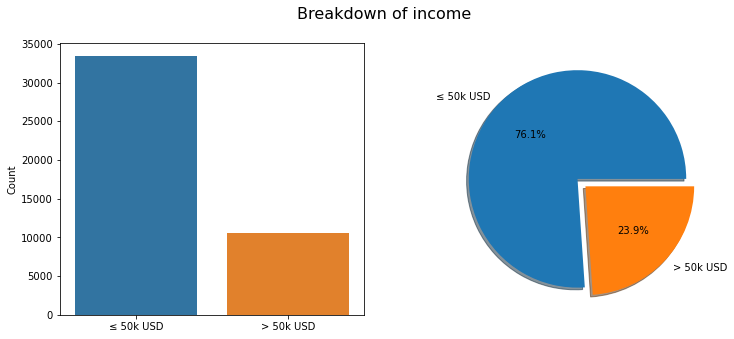

In [5]:
values = data['income_>50K'].value_counts()
labels = ['≤ 50k USD', '> 50k USD']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle('Breakdown of income', fontsize=16)
sns.countplot(x='income_>50K', data=data, ax=axs[0])
axs[0].set(xlabel="", ylabel = "Count", xticklabels=labels)
axs[1].pie(values, labels=labels, 
    autopct='%1.1f%%', shadow=True, explode=[0,0.1])
plt.show()

#### Observations:
As we can see, only **23.9%** of our chosen sample (10518 people) reach annual income of more than 50k USD. <br><br>
Further in the notebook we will try to analyze wich features have the greatest impact on high income. Based on that, we will try to create model that accurately predicts whatever given person earns more than 50k USD a year.

#### + Relation between earnings and gender

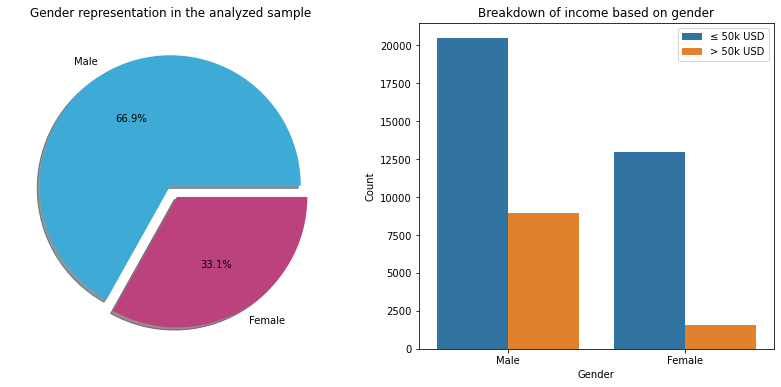

In [7]:
values = data['gender'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].pie(values, labels=['Male', 'Female'], colors=['#3DABD5', '#BB427D'],
    autopct='%1.1f%%', shadow=True, explode=[0, 0.1])
axs[0].set_title('Gender representation in the analyzed sample')

sns.countplot(x='gender', hue='income_>50K', data=data, ax=axs[1])
axs[1].set(title='Breakdown of income based on gender', xlabel='Gender', ylabel = 'Count')
axs[1].legend(labels)
plt.show()

In [29]:
pd.crosstab(data['income_>50K'], data['gender'], rownames=['Income > 50k USD'], margins=True)

gender,Female,Male,All
Income > 50k USD,,,
0,12967,20472,33439
1,1590,8928,10518
All,14557,29400,43957


#### Observations:
1. The number of children increases with Pclass and the survival rate for passenegers below Age 10(i.e children) looks to be good irrespective of the Pclass. <br>
2. Survival chances for Passenegers aged 20-50 from Pclass1 is high and is even better for Women. <br>
3. For males, the survival chances decreases with an increase in age.

#### + Relation between earnings and age

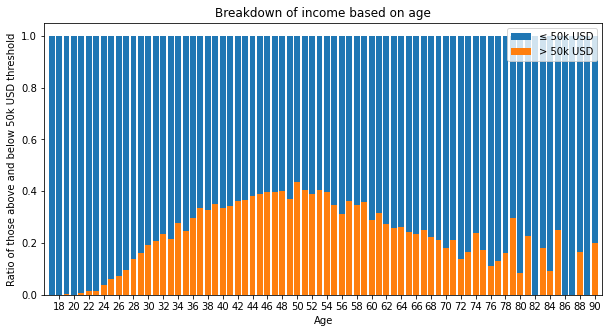

In [8]:
min_age = data['age'].min()
max_age = data['age'].max()
labels = np.arange(min_age, max_age+1)

below = data[['age', 'income_>50K']][data['income_>50K'] == 0].groupby('age').count().squeeze()
above = data[['age', 'income_>50K']][data['income_>50K'] == 1].groupby('age').count().squeeze()

# Fill missing keys
missing_keys = below.keys().difference(above.keys())
missing_keys = missing_keys.to_series()
missing_keys[:] = 0
above = above.add(missing_keys, fill_value=0)

# Represent as ratio
all = below + above
above = above / all
below = 1

fig, axs = plt.subplots(figsize=(10, 5))
axs.bar(labels, below, label='≤ 50k USD')
axs.bar(labels, above, label='> 50k USD')
axs.set(title='Breakdown of income based on age', xlabel='Age', ylabel='Ratio of those above and below 50k USD threshold')
axs.set(xlim=(16,91), xticks=np.arange(18,92,2))
axs.legend(loc='upper right')

plt.show()

#### Observations:
1. The number of children increases with Pclass and the survival rate for passenegers below Age 10(i.e children) looks to be good irrespective of the Pclass. <br>
2. Survival chances for Passenegers aged 20-50 from Pclass1 is high and is even better for Women. <br>
3. For males, the survival chances decreases with an increase in age. <br>


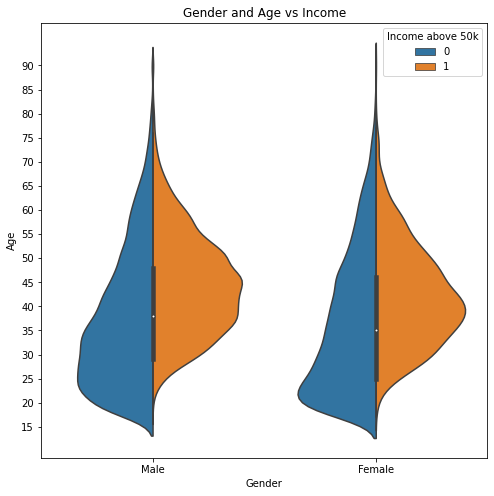

In [9]:
fig, axs = plt.subplots(figsize=(8, 8))

sns.violinplot(x="gender", y="age", hue='income_>50K', data=data, split=True, ax=axs)
axs.set(title='Gender and Age vs Income', xlabel='Gender', ylabel='Age')
axs.set_yticks(range(15,95,5))
axs.legend(title="Income above 50k")

plt.show()

#### Observations:
1. The number of children increases with Pclass and the survival rate for passenegers below Age 10(i.e children) looks to be good irrespective of the Pclass. <br>
2. Survival chances for Passenegers aged 20-50 from Pclass1 is high and is even better for Women. <br>
3. For males, the survival chances decreases with an increase in age. <br>

#### + Relation between earnings and education

In [110]:
# Prepare sorted keys values for plot
arg_sort = data['educational-num'].unique().argsort()
keys_pre_hs = data['education'].unique()[arr1inds][:8]
keys_post_hs = data['education'].unique()[arr1inds][8:]
print('Pre highschool: ', keys_pre_hs)
print('post highschool: ', keys_post_hs)

Pre highschool:  ['Preschool' '1st-4th' '5th-6th' '7th-8th' '9th' '10th' '11th' '12th']
post highschool:  ['HS-grad' 'Some-college' 'Assoc-voc' 'Assoc-acdm' 'Bachelors' 'Masters'
 'Prof-school' 'Doctorate']


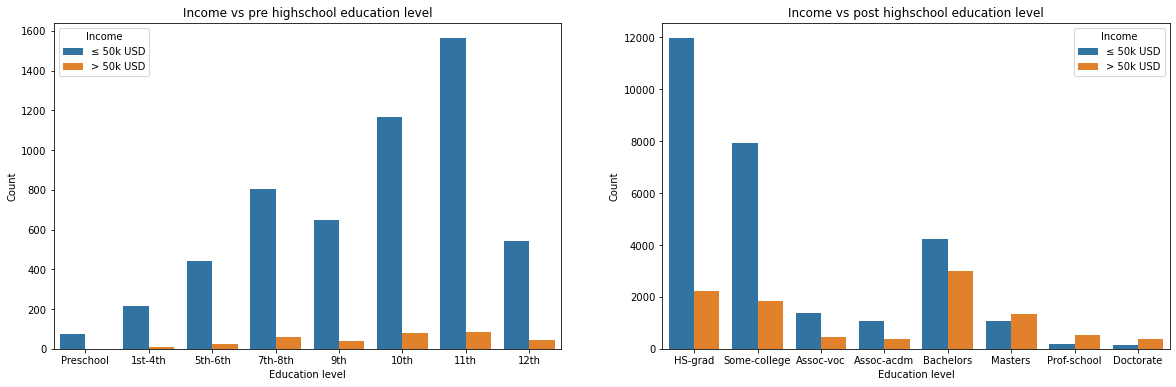

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(x='education', hue='income_>50K', order=keys_pre_hs, 
    data=data[data['education'].isin(keys_pre_hs)], ax=axs[0])
axs[0].set(title='Income vs pre highschool education level', xlabel='Education level', ylabel = 'Count')
axs[0].legend(title="Income", labels=['≤ 50k USD', '> 50k USD'])

sns.countplot(x='education', hue='income_>50K', order=keys_post_hs, 
    data=data[data['education'].isin(keys_post_hs)], ax=axs[1])
axs[1].set(title='Income vs post highschool education level', xlabel='Education level', ylabel = 'Count')
axs[1].legend(title="Income", labels=['≤ 50k USD', '> 50k USD'])
plt.show()

In [195]:
crosstab = pd.crosstab(data['income_>50K'], data['educational-num'],
    rownames=['Income > 50k USD'], colnames=['Education level'], margins=True)

keys = data['education'].unique()[arr1inds]
new_columns = {old : new for old, new in zip(crosstab.columns, keys)}
crosstab.rename(columns=new_columns, inplace=True)
crosstab

Education level,Preschool,1st-4th,5th-6th,7th-8th,9th,10th,11th,12th,HS-grad,Some-college,Assoc-voc,Assoc-acdm,Bachelors,Masters,Prof-school,Doctorate,All
Income > 50k USD,,,,,,,,,,,,,,,,,
0,75,216,442,805,647,1168,1563,543,11973,7940,1362,1062,4230,1064,197,152,33439
1,1,7,26,57,37,82,84,44,2224,1850,469,385,2989,1328,551,384,10518
All,76,223,468,862,684,1250,1647,587,14197,9790,1831,1447,7219,2392,748,536,43957


#### Observations:
1. The number of children increases with Pclass and the survival rate for passenegers below Age 10(i.e children) looks to be good irrespective of the Pclass. <br>
2. Survival chances for Passenegers aged 20-50 from Pclass1 is high and is even better for Women. <br>
3. For males, the survival chances decreases with an increase in age. <br>

#### + Summary - correlation matrix

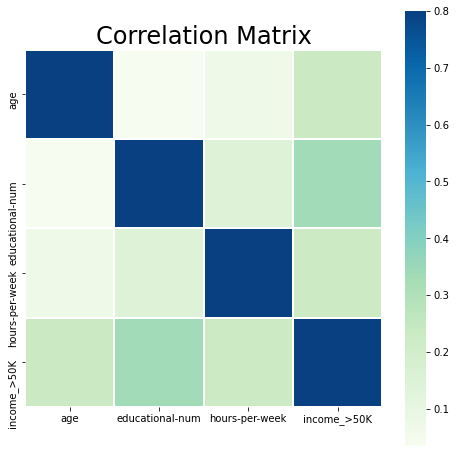

In [198]:
plt.figure(figsize=(8,8))
plt.title('Correlation Matrix',fontsize=24)
sns.heatmap(data.corr(), linewidths=0.1, vmax=0.8, square=True, cmap="GnBu",
    linecolor='w', annot=False)
plt.show()

In [201]:
data['education'].get_dummies().values

AttributeError: 'Series' object has no attribute 'get_dummies'

## Data cleaning
***

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   education        43957 non-null  object
 3   educational-num  43957 non-null  int64 
 4   marital-status   43957 non-null  object
 5   occupation       41451 non-null  object
 6   relationship     43957 non-null  object
 7   race             43957 non-null  object
 8   gender           43957 non-null  object
 9   hours-per-week   43957 non-null  int64 
 10  native-country   43194 non-null  object
 11  income_>50K      43957 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 4.0+ MB


In [ ]:
data['occupation'].unique()

## Building classification model
***